In [1]:
from utils import compute_errorRate
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from classification_dataset_preprocessing import *
import partition_dataset as partitions
import uuid
from collections import OrderedDict
from collections import Counter
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from random import sample
import copy

from fedml import run_experiment, run_PIL, run_baggingPIL, tune_federated_averaging,run_FedAveraging
%load_ext autoreload
%autoreload 2

%pylab inline

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

C:\Users\ma10s\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
E1109 09:58:19.659200  8364 ultratb.py:147] Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\ma10s\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-1-18477ef90465>", line 16, in <module>
    from fedml import run_experiment, run_PIL, run_baggingPIL, tune_federated_averaging,run_FedAveraging
  File "C:\Users\ma10s\Documents\fedml\fedml.py", line 20, in <module>
    import keras
  File "C:\Users\ma10s\Anaconda3\lib\site-packages\keras\__init__.py", line 3, in <module>
    from . import utils
  File "C:\Users\ma10s\Anaconda3\lib\site-packages\keras\utils\__init__.py", line 26, in <module>
    from .vis_utils import model_to_dot
  File "C:\Users\ma10s\Anaconda3\lib\site-packages\keras\utils\vis_utils.py", line 7, in <module>
    from ..models import Model
  File "C:\Users\ma10s\Anaconda3\lib\site-packages\keras\models.py", line 10, in <module>
    from .engine.input_layer import Input
  File "C:\Users\ma10s\Anaconda3\

ModuleNotFoundError: No module named 'tensorflow_core.keras'

In [3]:
x, y = load_spambase_data()
#x, y = load_covertype_dataset()
#x, y = load_breast_cancer_data()
#x, y = load_adult_dataset()
#x, y = load_Phishing_dataset()

# Sklearn SGDClassifier base learners (Federated SVM)

### Simple partial incremental learner  (orchestration scheme)
Each member trains a partial fit on local data sequentially. This is the simplest form of orchestration/global traing, but has limited parallelization potential  

In [4]:
score, training_loss, test_loss = run_PIL(x,y,20,parameters = {"nr_global_iterations": 1000, "nr_local_iterations":1} )

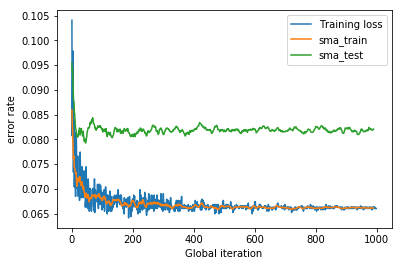

In [5]:
plt.plot(training_loss)
plt.plot(moving_average(training_loss,10))
plt.plot(moving_average(test_loss,10))
plt.ylabel('error rate')
plt.xlabel('Global iteration')
plt.legend(['Training loss', 'sma_train','sma_test'])

### Bagging partial incremental learners (orchestration scheme)
A number of PIL-models are trained on a subset of alliance members data (member_fraction). The global prediction is obtained by hard voting. This model can be parallized over subset learning. Also, member contributions can be purged from the global model at any point in time without having to start from scratch.  

In [74]:
parameters = {"number_of_models":100, "member_fraction":0.2, "nr_global_iterations": 10, "nr_local_iterations":1}
score, training_loss, test_loss = run_baggingPIL(x,y,100,parameters=parameters)

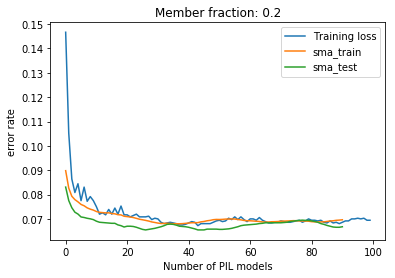

In [75]:
plt.plot(training_loss)
plt.plot(moving_average(training_loss,10))
plt.plot(moving_average(test_loss,10))
plt.title("Member fraction: {0}".format(parameters["member_fraction"]))
plt.ylabel('error rate')
plt.xlabel('Number of PIL models')
plt.legend(['Training loss', 'sma_train','sma_test'])

### Federated SGD/Averaging (orchestration scheme)
Federated averaging as descibed in "Communication-Efficient Learning of Deep Networks from Decentralized Data
" https://arxiv.org/abs/1602.05629 

In [76]:
parameters = { "nr_global_iterations": 1000, "nr_local_iterations":1}
score, training_loss, test_loss = run_FedAveraging(x,y,20,parameters=parameters)

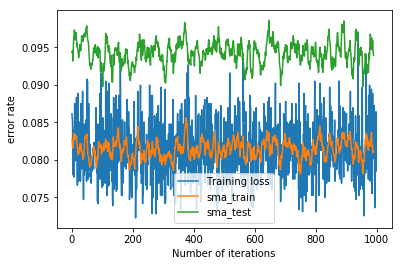

In [77]:
plt.plot(training_loss)
plt.plot(moving_average(training_loss,10))
plt.plot(moving_average(test_loss,10))
plt.ylabel('error rate')
plt.xlabel('Number of iterations')
plt.legend(['Training loss', 'sma_train','sma_test'])

# A FedML Keras CNN model for hand-written digit classification

In [78]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from fedml import KerasSequentialBaseLearner, PartialIncrementalLearnerClassifier, FedAveragingClassifier

## First develop a base model (model initiator)

In [79]:
from read_data import read_training_data
def scale_and_reshape(x_train,y_train):
    img_rows, img_cols = 28, 28
    num_classes = 10
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    x_train = x_train.astype('float32')
    x_train /= 255
    y_train = keras.utils.to_categorical(y_train, num_classes)
    return x_train, y_train

In [80]:
#from read_data import read_training_data

# input image dimensions
img_rows, img_cols = 28, 28
num_classes = 10

# input image dimensions
dim=img_rows, img_cols 
input_shape = (dim[0], dim[1], 1)
num_classes = num_classes

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
           activation='relu',
           input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy,optimizer=keras.optimizers.Adadelta(),metrics=['accuracy'])

In [81]:
# All this will be as implemented in fyrai/federated
from fedml import Alliance, AllianceMember

alliance = Alliance()
M=2
for i in range(M):
    x_train, y_train,classes = read_training_data(sample_fraction=0.01)
    x_train,y_train = scale_and_reshape(x_train,y_train)
    member = AllianceMember(x_train, y_train, classes=classes)
    alliance.add_member(member)

In [82]:
base_learner = KerasSequentialBaseLearner(model)

In [83]:
pil_model = PartialIncrementalLearnerClassifier(alliance=alliance,base_learner=base_learner)

In [84]:
parameters = {"nr_global_iterations": 10, "nr_local_iterations":1} 
training_loss, test_loss = pil_model.fit(parameters)

Epoch 1/1
600/600 [==============================] - 4s 7ms/step - loss: 1.7833 - acc: 0.3933
Epoch 1/1
600/600 [==============================] - 1s 1ms/step - loss: 1.0961 - acc: 0.6517


TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

In [19]:
fedavg_model = FedAveragingClassifier(alliance=alliance,base_learner=base_learner)

In [15]:
parameters = {"nr_global_iterations": 1, "nr_local_iterations":1} 
training_loss, test_loss = fedavg_model.fit(parameters)

Epoch 1/1
600/600 [==============================] - 1s 2ms/step - loss: 1.8537 - acc: 0.3500
Epoch 1/1
600/600 [==============================] - 1s 2ms/step - loss: 1.8084 - acc: 0.3783
Epoch 1/1
600/600 [==============================] - 1s 2ms/step - loss: 0.9547 - acc: 0.6850
Epoch 1/1
600/600 [==============================] - 2s 3ms/step - loss: 1.0261 - acc: 0.6717
Epoch 1/1
600/600 [==============================] - 2s 3ms/step - loss: 0.6192 - acc: 0.8200A: 0s - loss: 0.6193 - acc: 0.81
Epoch 1/1
600/600 [==============================] - 2s 3ms/step - loss: 0.6712 - acc: 0.7933
Epoch 1/1
600/600 [==============================] - 2s 3ms/step - loss: 0.4309 - acc: 0.8483
Epoch 1/1
600/600 [==============================] - 2s 3ms/step - loss: 0.4643 - acc: 0.8567
Epoch 1/1
600/600 [==============================] - 2s 3ms/step - loss: 0.3287 - acc: 0.8967
Epoch 1/1
600/600 [==============================] - 2s 3ms/step - loss: 0.4384 - acc: 0.8650
Epoch 1/1
600/600 [=========

In [179]:
np.shape(x_train[0:,::])
y=pil_model.predict(x_train[0:2,::])
y

IndexError: index 13 is out of bounds for axis 1 with size 10